# Exploration of potential `barber` methods

The Barber should use some method to define bin definition criteria from a set of galaxy photometry without knowing the galaxy redshifts.
The Barber will then be judged by the performance of those bin definitions in the space of true redshifts of those galaxies.

In [2]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

import os
from urllib.request import urlretrieve
import warnings
import h5py
import numpy as np

Automatically created module for IPython interactive environment


## Load data

We'll start with code from [tomo\_challenge](https://github.com/LSSTDESC/tomo_challenge/blob/master/tomo_challenge/data.py) (copied for now, until it becomes installable).

In [3]:
# # ============
# # Generate datasets. We choose the size big enough to see the scalability
# # of the algorithms, but not too big to avoid too long running times
# # ============
# n_samples = 1500
# noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
#                                       noise=.05)
# noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
# blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
# no_structure = np.random.rand(n_samples, 2), None

# # Anisotropicly distributed data
# random_state = 170
# X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
# transformation = [[0.6, -0.6], [-0.4, 0.8]]
# X_aniso = np.dot(X, transformation)
# aniso = (X_aniso, y)

# # blobs with varied variances
# varied = datasets.make_blobs(n_samples=n_samples,
#                              cluster_std=[1.0, 2.5, 0.5],
#                              random_state=random_state)



nersc_path = '/global/projecta/projectdirs/lsst/groups/WL/users/zuntz/tomo_challenge_data/'
url_root =  'https://portal.nersc.gov/project/lsst/txpipe/tomo_challenge_data/'
# This is not supposed to be needed - I don't understand why in my shifter env the warning
# is being repeated.
warned = False

def load_magnitudes_and_colors(filename, bands):
    """Load magnitudes, and compute colors from them,
    from a training or validation file.

    Note that there are other columns available in
    the files that this function does not load, but are
    available for your methods (mag errors, size, s/n).

    Parameters
    ----------
    filename: str
        The name of the file to read, e.g. riz/training.hdf5

    bands: str
        The list of bands to read from the data

    Returns
    -------
    data: array
        Dimension is nfeature x nrow, where nfeature = nband + ncolor
        and ncolor = nband * (nband - 1) / 2
    """

    # Open the data file
    f = h5py.File(filename)

    # Get the number of features (mags + colors)
    # and data points
    ndata = f['ra'].size
    nband = len(bands)
    ncolor = (nband * (nband - 1)) // 2
    nfeature = nband + ncolor

    # np.empty is like np.zeros except it doesn't
    # bother filling in the data with zeros, just
    # allocates space.  We can use it because we
    # are filling it in in a moment.  This gets
    # transposed before we return it to match
    # what sklearn expects
    data = np.empty((nfeature, ndata))

    # Read the magnitudes into the array
    for i, b in enumerate(bands):
        data[i] = f['mcal_mag_{}'.format(b)][:]

    f.close()
    global warned
    if not warned:
        warnings.warn("Setting inf (undetected) bands to mag=30")
        warned = True
    data[:nband][~np.isfinite(data[:nband])] = 30.0

    # Starting column for the colors
    n = nband

    # also get colors as data, from all the
    # (non-symmetric) pairs.  Note that we are getting some
    # redundant colors here, and some incorrect colors based
    # on the choice to set undetected magnitudes to 30.
    for i in range(nband):
        for j in range(i+1, nband):
            data[n] = data[i] - data[j]
            n += 1
    
    # Return the data. sklearn wants it the other way around
    # because data scientists are weird and think of data as
    # lots of rows instead of lots of columns.
    return data.T

def load_redshift(filename):
    """Load a redshift column from a training or validation file"""
    f = h5py.File(filename)
    z = f['redshift_true'][:]
    f.close()
    return z

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Setting inf (undetected) bands to mag=30


In [ ]:
# take a subsample of size from sklearn example for now
X = load_magnitudes_and_colors('/global/projecta/projectdirs/lsst/groups/WL/users/zuntz/tomo_challenge_data/riz/training.hdf5', 'riz')[:1500, :3]

In [8]:
# try it with colors and one magnitude
Xdifs = np.array([X[:,0], X[:,0]-X[:,1], X[:,1]-X[:,2]]).T

## Unsupervised clustering to define bins

We want to do something like [this](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py), exploring methods to make bin definitions in the space of photometry.
We're starting with a simple GMM with a pre-specified number of bins.

TODO:
- try more unsupervised methods (see sklearn demo)
- incorporate errors and/or feature selection
- use probability over space to define bins in color/mag space
- model selection for nbins

In [10]:
# colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']), int(max(y_pred) + 1))))
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
nbins = len(colors)
# add black color for outliers (if any)
# colors = np.append(colors, ["#000000"])

In [14]:
gmm = mixture.GaussianMixture(n_components=nbins, covariance_type='full')
Y = gmm.fit_predict(X)
Ydifs = gmm.fit_predict(Xdifs)

Plot preliminary results

TODO:
- fix broken number of panels
- fix axis labels/twinning

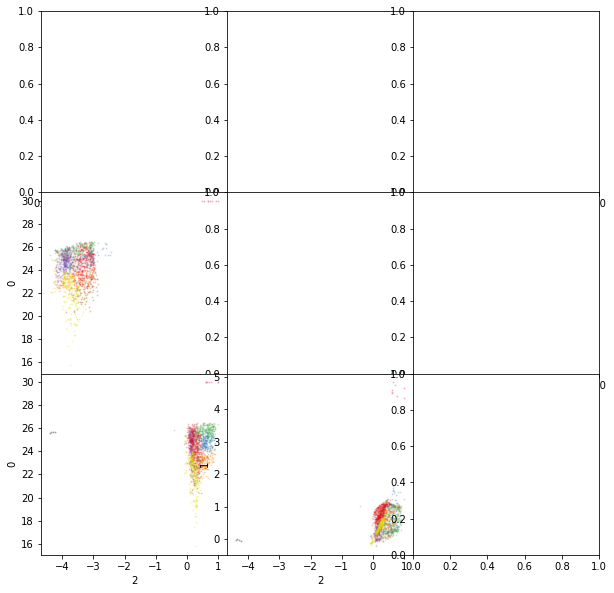

In [13]:
def mytriangle(X, Y, colors):
    
    ngal, ndim = np.shape(X)
    nrow = ndim - 1
    cols, counts = np.unique(Y, return_counts=True)
    ncol = len(cols)
    
    fig = plt.figure(figsize=(nrow*(5), nrow*5))
    ax = [[fig.add_subplot(ndim, ndim, ndim * i + j + 1) for j in range(ndim)] for i in range(ndim)]
#     to_keep = range(nrow)#[0, 1, 2, 4]
    
    for k in range(ncol):
        Xplot = X[Y == k]
        for i in range(ndim):
            for j in range(i):
                ax[i][j].scatter(Xplot[:, i], Xplot[:, j], s=1, alpha=1./np.log(counts[k]), color=colors[k])
                ax[i][j].set_xlabel(str(i))
                ax[i][j].set_ylabel(str(j))
    plt.subplots_adjust(hspace=0., wspace=0.)
#     plt.savefig('mixmod.png', dpi=100, bbox_inches='tight', pad_inches = 0)
    return

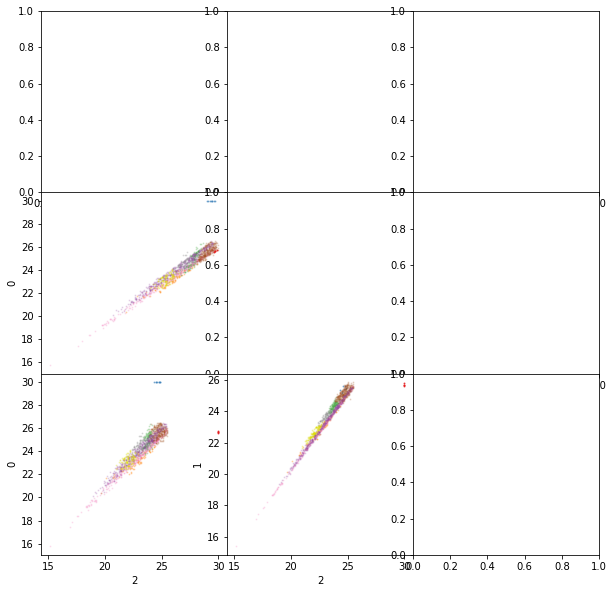

In [16]:
mytriangle(X, Y, colors)

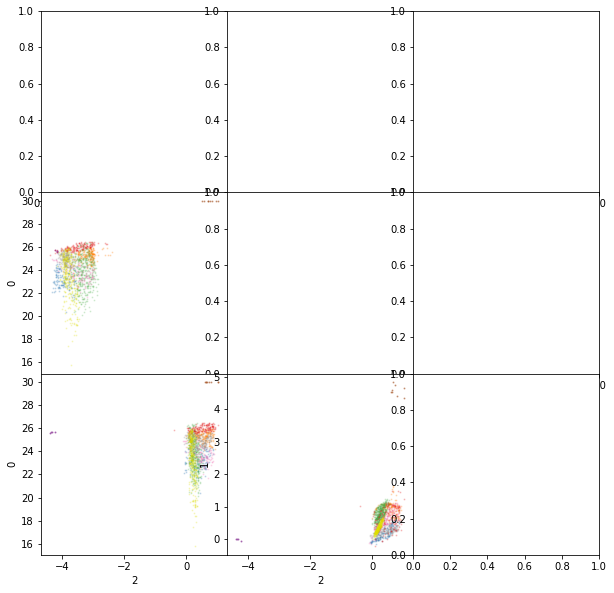

In [15]:
mytriangle(Xdifs, Ydifs, colors)

TODO: cut galaxies with placeholder values

## scratch

In [ ]:
# # ============
# # Set up cluster parameters
# # ============
# plt.figure(figsize=(9 * 2 + 3, 12.5))
# plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
#                     hspace=.01)

# plot_num = 1

# default_base = {'quantile': .3,
#                 'eps': .3,
#                 'damping': .9,
#                 'preference': -200,
#                 'n_neighbors': 10,
#                 'n_clusters': 3,
#                 'min_samples': 20,
#                 'xi': 0.05,
#                 'min_cluster_size': 0.1}

# datasets = [
#     (noisy_circles, {'damping': .77, 'preference': -240,
#                      'quantile': .2, 'n_clusters': 2,
#                      'min_samples': 20, 'xi': 0.25}),
#     (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
#     (varied, {'eps': .18, 'n_neighbors': 2,
#               'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
#     (aniso, {'eps': .15, 'n_neighbors': 2,
#              'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
#     (blobs, {}),
#     (no_structure, {})]

# for i_dataset, (dataset, algo_params) in enumerate(datasets):
#     # update parameters with dataset-specific values
#     params = default_base.copy()
#     params.update(algo_params)

#     X, y = dataset

#     # normalize dataset for easier parameter selection
#     X = StandardScaler().fit_transform(X)

#     # estimate bandwidth for mean shift
#     bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

#     # connectivity matrix for structured Ward
#     connectivity = kneighbors_graph(
#         X, n_neighbors=params['n_neighbors'], include_self=False)
#     # make connectivity symmetric
#     connectivity = 0.5 * (connectivity + connectivity.T)

#     # ============
#     # Create cluster objects
#     # ============
#     ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
#     two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
#     ward = cluster.AgglomerativeClustering(
#         n_clusters=params['n_clusters'], linkage='ward',
#         connectivity=connectivity)
#     spectral = cluster.SpectralClustering(
#         n_clusters=params['n_clusters'], eigen_solver='arpack',
#         affinity="nearest_neighbors")
#     dbscan = cluster.DBSCAN(eps=params['eps'])
#     optics = cluster.OPTICS(min_samples=params['min_samples'],
#                             xi=params['xi'],
#                             min_cluster_size=params['min_cluster_size'])
#     affinity_propagation = cluster.AffinityPropagation(
#         damping=params['damping'], preference=params['preference'])
#     average_linkage = cluster.AgglomerativeClustering(
#         linkage="average", affinity="cityblock",
#         n_clusters=params['n_clusters'], connectivity=connectivity)
#     birch = cluster.Birch(n_clusters=params['n_clusters'])
#     gmm = mixture.GaussianMixture(
#         n_components=params['n_clusters'], covariance_type='full')

#     clustering_algorithms = (
#         ('MiniBatchKMeans', two_means),
#         ('AffinityPropagation', affinity_propagation),
#         ('MeanShift', ms),
#         ('SpectralClustering', spectral),
#         ('Ward', ward),
#         ('AgglomerativeClustering', average_linkage),
#         ('DBSCAN', dbscan),
#         ('OPTICS', optics),
#         ('Birch', birch),
#         ('GaussianMixture', gmm)
#     )

#     for name, algorithm in clustering_algorithms:
#         t0 = time.time()

#         # catch warnings related to kneighbors_graph
#         with warnings.catch_warnings():
#             warnings.filterwarnings(
#                 "ignore",
#                 message="the number of connected components of the " +
#                 "connectivity matrix is [0-9]{1,2}" +
#                 " > 1. Completing it to avoid stopping the tree early.",
#                 category=UserWarning)
#             warnings.filterwarnings(
#                 "ignore",
#                 message="Graph is not fully connected, spectral embedding" +
#                 " may not work as expected.",
#                 category=UserWarning)
#             algorithm.fit(X)

#         t1 = time.time()
#         if hasattr(algorithm, 'labels_'):
#             y_pred = algorithm.labels_.astype(np.int)
#         else:
#             y_pred = algorithm.predict(X)

#         plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
#         if i_dataset == 0:
#             plt.title(name, size=18)

#         colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
#                                              '#f781bf', '#a65628', '#984ea3',
#                                              '#999999', '#e41a1c', '#dede00']),
#                                       int(max(y_pred) + 1))))
#         # add black color for outliers (if any)
#         colors = np.append(colors, ["#000000"])
#         plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

#         plt.xlim(-2.5, 2.5)
#         plt.ylim(-2.5, 2.5)
#         plt.xticks(())
#         plt.yticks(())
#         plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
#                  transform=plt.gca().transAxes, size=15,
#                  horizontalalignment='right')
#         plot_num += 1

# plt.show()